In [1]:
import requests

import json
import os

import pandas as pd

import sys, traceback
import mwreverts.api
import mwapi

# We'll use the mwreverts API check.  In order to do that, we need an API session
session = mwapi.Session("https://en.wikipedia.org", 
                        user_agent="Max Klein Newcomer Quality <max@notconfusing.com>")

import datetime as dt


from collections import defaultdict

from sklearn_pandas import DataFrameMapper, cross_val_score


import pandas as pd
pd.set_option('display.max_colwidth', 250)
import numpy as np
import sklearn.preprocessing, sklearn.linear_model, sklearn.metrics, sklearn.ensemble
import sklearn.model_selection

import pickle

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


def wlink(rev_id):
    return f'https://en.wikipedia.org/w/index.php?diff=prev&oldid={rev_id}&diffmode=source'

In [2]:
endpoint = 'https://labels.wmflabs.org/campaigns/'

resp = requests.get(url=endpoint)
data = resp.json()

wikis = data['wikis']

mdtp_campaigns = {}

mdtp_tasks = {}

In [51]:
for wiki in wikis:
    wiki_endpoint = f'{endpoint}{wiki}'
#     print(wiki_endpoint)
    wiki_resp = requests.get(wiki_endpoint)
    wiki_data = wiki_resp.json()
    for campaign in wiki_data['campaigns']:
        if campaign['view'] == 'MultiDiffToPrevious':
            mdtp_campaigns[wiki] = campaign['id']

In [52]:
for k, v in mdtp_campaigns.items():
    campaign_endpoint = f'{endpoint}{k}/{v}/?tasks'
    print(campaign_endpoint)
    campaign_resp = requests.get(campaign_endpoint)
    campaign_data = campaign_resp.json()
    mdtp_tasks[k] = campaign_data['tasks']


for wiki, tasks in mdtp_tasks.items():
    print(f'wiki:{wiki}')
    completed = [t for t in tasks if t['labels']]
    with open('enwiki_newcomer_labelled_100.jsonl','w') as outf:
        for l in completed:
            rev_ids = l['data']['rev_ids']
            labels = l['labels'][0]['data']
            id_labels = {'rev_ids':rev_ids, **labels}
            outf.write(json.dumps(id_labels))
            outf.write('\n')
    print(f'{len(completed)} completed tasks of {len(tasks)} total')
#     for task in tasks:
#         lab = task['labels']
#         if lab:
#             print(lab)

https://labels.wmflabs.org/campaigns/enwiki/86/?tasks
wiki:enwiki
436 completed tasks of 1989 total


# Check the singletons

In [53]:
def perc_singleton(fname):
    rev_lens = []
    with open(fname,'r') as f:
        for line in f:
            d = json.loads(line)
            rev_ids  = d['rev_ids']
            rev_lens.append(len(rev_ids))

    num_singleton = len([l for l in rev_lens if l==1])
    perc_singleton =  num_singleton / len(rev_lens)
    return num_singleton, perc_singleton

In [54]:
jsonls = [f for f in os.listdir('.') if f.endswith('.jsonl')]
for jsonl in jsonls:
    print(jsonl, perc_singleton(jsonl))

enwiki_newcomer_labelled_100.jsonl (221, 0.5068807339449541)


# Get ORES data

In [55]:
completed_row_oriented = [{'task_id': c['id'],
                            'user_id':c['data']['user_id'],
                           'rev_ids':c['data']['rev_ids'],
                           'damaging_label':c['labels'][0]['data']['damaging'],
                           'goodfaith_label':c['labels'][0]['data']['goodfaith'],} for c in completed]

In [56]:
df = pd.DataFrame.from_dict(completed_row_oriented)

In [57]:
df = df[pd.notnull(df['goodfaith_label']) & pd.notnull(df['damaging_label'])] #no skipped ones

In [58]:
ores_string = 'https://ores.wikimedia.org/v3/scores/{context}/{revid}/{model}'
context = 'enwiki'
models = ('damaging', 'goodfaith')

In [59]:
def get_ores_data_dgf(rev_ids):
#     print(f'getting {len(rev_ids)} revs')
    ores_data = {}
    for model in ('damaging', 'goodfaith'):
        ores_data[model] = []
        for rev_id in rev_ids:
            ores_req = ores_string.format(context=context, revid=rev_id, model=model)
            ores_resp = requests.get(url=ores_req)
            json_data = ores_resp.json()
            try:
                ores_datum_raw = json_data[context]['scores'][str(rev_id)][model]['score']
                ores_datum = {'prediction':ores_datum_raw['prediction'],'prob_true':ores_datum_raw['probability']['true']}
                ores_data[model].append(ores_datum)
            except KeyError:
                ores_data[model].append(float('nan'))
    return ores_data

In [60]:
df['ores_data'] = df['rev_ids'].apply(get_ores_data_dgf)


KeyboardInterrupt: 

In [ ]:
df.to_pickle('/home/paprika/workspace/wikilabels_data/saves/exp_v1_with_ores_scores.pickle')

df = pd.read_pickle('/home/paprika/workspace/wikilabels_data/saves/exp_v1_with_ores_scores.pickle')

In [27]:
df.head()

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data
0,False,True,[764113608],558731,30282906,"{'damaging': [{'prediction': False, 'prob_true': 0.15501228732476371}], 'goodfaith': [{'prediction': True, 'prob_true': 0.976423405666497}]}"
1,False,True,"[763924694, 763926307, 763930716, 763931301, 763932010]",558733,30282911,"{'damaging': [{'prediction': False, 'prob_true': 0.09601118263157825}, {'prediction': False, 'prob_true': 0.23005538799402592}, {'prediction': False, 'prob_true': 0.3725931153402145}, {'prediction': False, 'prob_true': 0.2364148442188683}, {'pred..."
2,False,True,"[764251399, 764252150, 764253295, 764257845]",558734,30282911,"{'damaging': [{'prediction': False, 'prob_true': 0.04356904152227608}, {'prediction': False, 'prob_true': 0.4499425384549236}, {'prediction': False, 'prob_true': 0.22013728098376725}, {'prediction': False, 'prob_true': 0.06750852803308395}], 'goo..."
3,False,True,[763918492],558737,30282924,"{'damaging': [{'prediction': True, 'prob_true': 0.6152127780999527}], 'goodfaith': [{'prediction': True, 'prob_true': 0.5972110083906026}]}"
4,False,True,[763917983],558741,30282943,"{'damaging': [{'prediction': False, 'prob_true': 0.27870679674580473}], 'goodfaith': [{'prediction': True, 'prob_true': 0.8745512035659346}]}"


In [28]:
df['damaging_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['damaging'] if isinstance(e, dict)])
df['goodfaith_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['goodfaith'] if isinstance(e, dict)])
df['damaging_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['damaging'] if isinstance(e, dict)])
df['goodfaith_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['goodfaith'] if isinstance(e, dict)])

In [29]:
df = df[df['damaging_scores'].apply(lambda l:len(l)>0)] # drop out nan results

In [30]:
df['goodfaith_session_edit_mismatch'] = df[['goodfaith_label','goodfaith_predictions']].apply(lambda row: not(row['goodfaith_label'] in row['goodfaith_predictions']), axis=1)
df['damaging_session_edit_mismatch'] = df[['damaging_label','damaging_predictions']].apply(lambda row: not(row['damaging_label'] in row['damaging_predictions']), axis=1)

In [31]:
goodfaith_mismatches = df[df['goodfaith_session_edit_mismatch']==True]
damaging_mismatches = df[df['damaging_session_edit_mismatch']==True]

In [32]:
print(f'len goodfaith mistmatches: {len(goodfaith_mismatches)}')
print(f'len damaging mistmatches: {len(damaging_mismatches)}')

len goodfaith mistmatches: 59
len damaging mistmatches: 80


In [323]:
goodfaith_mismatches['wlinks'] = goodfaith_mismatches['rev_ids'].apply(lambda rl: [wlink(r) for r in rl])
damaging_mismatches['wlinks'] = damaging_mismatches['rev_ids'].apply(lambda rl: [wlink(r) for r in rl])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [324]:
goodfaith_mismatches[goodfaith_mismatches['rev_ids'].apply(lambda l:len(l)>1)]

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data,damaging_scores,goodfaith_scores,damaging_predictions,goodfaith_predictions,goodfaith_session_edit_mismatch,damaging_session_edit_mismatch,wlinks
25,True,False,"[763926298, 763926606]",558838,30283258,"{'damaging': [{'prediction': False, 'prob_true': 0.4730587747991271}, {'prediction': True, 'prob_true': 0.7440500123958258}], 'goodfaith': [{'prediction': True, 'prob_true': 0.6616573843599153}, {'prediction': True, 'prob_true': 0.575930360909807...","[0.4730587747991271, 0.7440500123958258]","[0.6616573843599153, 0.5759303609098076]","[False, True]","[True, True]",True,False,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763926298&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763926606&diffmode=source]"
29,True,True,"[763929270, 763930145]",558858,30283361,"{'damaging': [{'prediction': True, 'prob_true': 0.7183727092044194}, {'prediction': True, 'prob_true': 0.8418168665142072}], 'goodfaith': [{'prediction': False, 'prob_true': 0.372561553827677}, {'prediction': False, 'prob_true': 0.319276701933801...","[0.7183727092044194, 0.8418168665142072]","[0.372561553827677, 0.3192767019338014]","[True, True]","[False, False]",True,False,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763929270&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763930145&diffmode=source]"
34,True,False,"[763931594, 763931748, 763931985, 763932104, 763932276, 763932378, 763932518, 763932758, 763932820, 763932978, 763933076, 763933123]",558873,30283433,"{'damaging': [{'prediction': False, 'prob_true': 0.04855927009982969}, {'prediction': False, 'prob_true': 0.04827772144830002}, {'prediction': False, 'prob_true': 0.047270077026541145}, {'prediction': False, 'prob_true': 0.03892583587509084}, {'p...","[0.04855927009982969, 0.04827772144830002, 0.047270077026541145, 0.03892583587509084, 0.03530222554171994, 0.03530222554171994, 0.03530222554171994, 0.03422691310387431, 0.03422691310387431, 0.033474584319137586, 0.033474584319137586, 0.033474584...","[0.9746022472848997, 0.9755450130495057, 0.9766892085100262, 0.978706851093428, 0.978252465812957, 0.978252465812957, 0.9781831673783714, 0.9802579909246855, 0.9802579909246855, 0.9802010540068654, 0.9806229940439372, 0.9806229940439372]","[False, False, False, False, False, False, False, False, False, False, False, False]","[True, True, True, True, True, True, True, True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931594&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931748&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931985&diffmode=source, https..."
39,True,False,"[763948318, 763948569, 763948921]",558882,30283483,"{'damaging': [{'prediction': False, 'prob_true': 0.051086111591214456}, {'prediction': False, 'prob_true': 0.33772422341948266}, {'prediction': False, 'prob_true': 0.08932391658798042}], 'goodfaith': [{'prediction': True, 'prob_true': 0.985714294...","[0.051086111591214456, 0.33772422341948266, 0.08932391658798042]","[0.9857142949465324, 0.9208009878954571, 0.9803447840612858]","[False, False, False]","[True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948318&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948569&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948921&diffmode=source]"
47,True,False,"[763945255, 763945337, 763947098, 763947299, 763947374]",558920,30283679,"{'damaging': [{'prediction': False, 'prob_true': 0.020456219200129168}, {'prediction': False, 'prob_true': 0.02267604719777314}, {'prediction': False, 'prob_true': 0.01743717378388933}, {'prediction': False, 'prob_true': 0.17915060506395433}, {'p...","[0.020456219200129168, 0.02267604719777314, 0.01743717378388933, 0.17915060506395433, 0.22398155772394754]","[0.9867851652787335, 0.9840186467666154, 0.9851928298489351, 0.9

In [325]:
damaging_mismatches[damaging_mismatches['rev_ids'].apply(lambda l:len(l)>1)]

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data,damaging_scores,goodfaith_scores,damaging_predictions,goodfaith_predictions,goodfaith_session_edit_mismatch,damaging_session_edit_mismatch,wlinks
34,True,False,"[763931594, 763931748, 763931985, 763932104, 763932276, 763932378, 763932518, 763932758, 763932820, 763932978, 763933076, 763933123]",558873,30283433,"{'damaging': [{'prediction': False, 'prob_true': 0.04855927009982969}, {'prediction': False, 'prob_true': 0.04827772144830002}, {'prediction': False, 'prob_true': 0.047270077026541145}, {'prediction': False, 'prob_true': 0.03892583587509084}, {'p...","[0.04855927009982969, 0.04827772144830002, 0.047270077026541145, 0.03892583587509084, 0.03530222554171994, 0.03530222554171994, 0.03530222554171994, 0.03422691310387431, 0.03422691310387431, 0.033474584319137586, 0.033474584319137586, 0.033474584...","[0.9746022472848997, 0.9755450130495057, 0.9766892085100262, 0.978706851093428, 0.978252465812957, 0.978252465812957, 0.9781831673783714, 0.9802579909246855, 0.9802579909246855, 0.9802010540068654, 0.9806229940439372, 0.9806229940439372]","[False, False, False, False, False, False, False, False, False, False, False, False]","[True, True, True, True, True, True, True, True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931594&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931748&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931985&diffmode=source, https..."
39,True,False,"[763948318, 763948569, 763948921]",558882,30283483,"{'damaging': [{'prediction': False, 'prob_true': 0.051086111591214456}, {'prediction': False, 'prob_true': 0.33772422341948266}, {'prediction': False, 'prob_true': 0.08932391658798042}], 'goodfaith': [{'prediction': True, 'prob_true': 0.985714294...","[0.051086111591214456, 0.33772422341948266, 0.08932391658798042]","[0.9857142949465324, 0.9208009878954571, 0.9803447840612858]","[False, False, False]","[True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948318&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948569&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948921&diffmode=source]"
43,False,False,"[763934049, 763934196, 763934324]",558894,30283552,"{'damaging': [{'prediction': True, 'prob_true': 0.7762776688360993}, {'prediction': True, 'prob_true': 0.6276607010744235}, {'prediction': True, 'prob_true': 0.7407605345081835}], 'goodfaith': [{'prediction': False, 'prob_true': 0.291930650099069...","[0.7762776688360993, 0.6276607010744235, 0.7407605345081835]","[0.2919306500990693, 0.5073118633667208, 0.4407799468961656]","[True, True, True]","[False, True, False]",False,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934049&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934196&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934324&diffmode=source]"
47,True,False,"[763945255, 763945337, 763947098, 763947299, 763947374]",558920,30283679,"{'damaging': [{'prediction': False, 'prob_true': 0.020456219200129168}, {'prediction': False, 'prob_true': 0.02267604719777314}, {'prediction': False, 'prob_true': 0.01743717378388933}, {'prediction': False, 'prob_true': 0.17915060506395433}, {'p...","[0.020456219200129168, 0.02267604719777314, 0.01743717378388933, 0.17915060506395433, 0.22398155772394754]","[0.9867851652787335, 0.9840186467666154, 0.9851928298489351, 0.9097528002582813, 0.8942124644148761]","[False, False, False, False, False]","[True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763945255&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763945337&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763947098&diffmode=source, https..."
80,True,False,"[764004719, 764006056]",559073,30284320,"{'damaging': [{'predictio

# TODO:Try a new label where the singletons are just the ores label

##  Get timestamps #

In [33]:
def get_rev_timestamps(revids):
    timestamps = []
    pages = []
    if len(revids)>50:
        print('truncating to 50 revids')
        revids=revids[:49]
    rev_query = session.get(action='query', prop='revisions', revids=revids)
    for page_id, page_info in rev_query['query']['pages'].items():
        page = {'page_id':page_id, 'page_ns':page_info['ns']}
        pages.append(page)
        revisions = page_info['revisions']
        for revision in revisions:
#             print(revision)
            timestamp = dt.datetime.strptime(revision['timestamp'],  "%Y-%m-%dT%H:%M:%SZ")
            timestamps.append(timestamp)
    return {'timestamps':timestamps, 'pages':pages}

In [34]:
df['timestamps_pages'] = df['rev_ids'].apply(lambda x: get_rev_timestamps(x))

truncating to 50 revids


In [35]:
df['timestamps'] = df['timestamps_pages'].apply(lambda d: d['timestamps'])
df['pages'] = df['timestamps_pages'].apply(lambda d: d['pages'])

In [329]:
df.to_pickle('saves/exp_v2_with_ores_scores.pickle')

df = pd.read_pickle('saves/exp_v2_with_ores_scores.pickle')

In [36]:
def num_reverts(revids):
    self_reverts = 0
    reverting_users = defaultdict(int)
    for rev_id in revids:
        try:
            _, reverted, reverted_to = mwreverts.api.check(
                session, rev_id, radius=2,  # most reverts within 5 edits
                window=48*60*60,  # 2 days
                rvprop={'user', 'ids'})  # Some properties we'll make use of
        except (RuntimeError, KeyError) as e:
            sys.stderr.write(str(e))
            continue
            
        if reverted is not None:
            
            reverting_user = reverted.reverting['user']
            reverting_users[reverting_user] += 1
            
            reverted_doc = [r for r in reverted.reverteds
                            if r['revid'] == rev_id][0]

            if 'user' not in reverted_doc or 'user' not in reverted.reverting:
                continue

            # self-reverts
            self_revert = \
                reverted_doc['user'] == reverting_user

            if self_revert:
                self_reverts += 1
    
    edit_war_users = [user for user, num_reverts in reverting_users.items() if num_reverts > 1]
    edit_wars = len(edit_war_users)
    
    return {'self_reverts': self_reverts, 'edit_wars':edit_wars}

In [37]:
df['revert_data'] = df['rev_ids'].apply(lambda x: num_reverts(x))

df['self_reverts'] = df['revert_data'].apply(lambda d: d['self_reverts'])
df['edit_wars'] = df['revert_data'].apply(lambda d: d['edit_wars'])

In [39]:
df['self_reverts'].value_counts()

0    411
1      8
5      1
Name: self_reverts, dtype: int64

In [40]:
df['edit_wars'].value_counts()

0    375
1     39
2      5
3      1
Name: edit_wars, dtype: int64

In [335]:
df.to_pickle('saves/exp_v3_with_ores_scores.pickle')

df = pd.read_pickle('saves/exp_v3_with_ores_scores.pickle')

# Class Priors

In [41]:
df['goodfaith_label'].sum() / len(df)

0.7428571428571429

In [42]:
df['damaging_label'].sum() / len(df)

0.39285714285714285


# Feature Engineering

## simple
+ mean scores, max scores, min scores, var scores, trend-line score, count scores

## temporal
+ total time, 

## added subtracted
+ total added, total subtracted, count additions, count subtractions, 

## self-reverts
+ self-reverts

In [43]:
# First do goodfaith
# the interesting part is where goodfaith session doesn't agree with goodfaith edits

In [44]:
np.polyfit([0,1],[0,2],1)

array([2.00000000e+00, 3.16375741e-17])

In [45]:
list(range(len([1,2])))

[0, 1]

In [46]:
def simp_lin_reg(vec,slope_intercept='slope'):
    if len(vec)==1:
        return 0
    else:
        x=list(range(len(vec)))
        reg = np.polyfit(x,vec,1)
        return reg[0] if slope_intercept == 'slope' else reg[1]

In [47]:
df['goodfaith_label_bin'] = df['goodfaith_label'].apply(lambda x: int(x))
df['damaging_label_bin'] = df['damaging_label'].apply(lambda x: int(x))

In [48]:
df['damaging_scores_mean'] = df['damaging_scores'].apply(np.mean)
df['damaging_scores_var'] = df['damaging_scores'].apply(np.var)
df['damaging_scores_max'] = df['damaging_scores'].apply(max)
df['damaging_scores_min'] = df['damaging_scores'].apply(min)
df['damaging_scores_reg_slope'] = df['damaging_scores'].apply(lambda v: simp_lin_reg(v,'slope'))
df['damaging_scores_reg_intercept'] = df['damaging_scores'].apply(lambda v: simp_lin_reg(v,'intercept'))
df['damaging_scores_count'] = df['damaging_scores'].apply(len)
df['damaging_scores_count_log'] = df['damaging_scores'].apply(lambda v: np.log(len(v)))

In [50]:
def total_seconds(timestamps):
    if len(timestamps)==1:
        return 60*60 # one hour
    else:
        delta = max(timestamps) - min(timestamps)
        return 60*60 + delta.seconds #one hour plus the difference
     
def fn_seconds(timestamps, fn):
    timestamps = sorted(timestamps)
    if len(timestamps)==1:
        return 0 #no variance
    else:
        deltas = []
        for i in range(len(timestamps)-1):
            deltas.append(timestamps[i+1]-timestamps[1])
        delta_seconds = [d.seconds for d in deltas]
        return fn(delta_seconds)

In [49]:
df['goodfaith_scores_mean'] = df['goodfaith_scores'].apply(np.mean)
df['goodfaith_scores_var'] = df['goodfaith_scores'].apply(np.var)
df['goodfaith_scores_max'] = df['goodfaith_scores'].apply(max)
df['goodfaith_scores_min'] = df['goodfaith_scores'].apply(min)
df['goodfaith_scores_reg_slope'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'slope'))
df['goodfaith_scores_reg_intercept'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'intercept'))
df['goodfaith_scores_count'] = df['goodfaith_scores'].apply(len)
df['goodfaith_scores_count_log'] = df['goodfaith_scores'].apply(lambda v: np.log(len(v)))

df['damaging_timestamps_total_seconds'] = df['timestamps'].apply(total_seconds)
df['damaging_timestamps_variance'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.var))
df['damaging_timestamps_min'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.min))
df['damaging_timestamps_max'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.max))

df['goodfaith_timestamps_total_seconds'] = df['timestamps'].apply(total_seconds)
df['goodfaith_timestamps_variance'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.var))
df['goodfaith_timestamps_min'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.min))
df['goodfaith_timestamps_max'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.max))

df['pages_unique_count'] = df['pages'].apply(lambda plist: len(set([p['page_id'] for p in plist])))
df['pages_namespace_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist])))
df['pages_nonmain_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']!=0])))
df['pages_talk_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']%2==1])))

df['singleton_session'] = df['rev_ids'].apply(lambda rev_ids: len(rev_ids)==1)

df['first_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: predictions[0])
df['first_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: predictions[0])
df['any_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: any(predictions))
df['any_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: any(predictions))



In [57]:
df.to_pickle('/home/paprika/workspace/wikilabels_data/saves/exp_v4_with_ores_scores.pickle')

In [87]:
df = pd.read_pickle('/home/paprika/workspace/wikilabels_data/saves/exp_v4_with_ores_scores.pickle')

In [88]:
df.shape

(420, 53)

In [89]:
mapper = DataFrameMapper([
(['goodfaith_scores_mean'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_var'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_max'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_min'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_reg_slope'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_reg_intercept'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_count'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_count_log'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_total_seconds'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_variance'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_min'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_max'], sklearn.preprocessing.StandardScaler()),
(['self_reverts'], sklearn.preprocessing.StandardScaler()),
(['edit_wars'], sklearn.preprocessing.StandardScaler()),
(['pages_unique_count'], sklearn.preprocessing.StandardScaler()),
(['pages_namespace_count'], sklearn.preprocessing.StandardScaler()),
(['pages_nonmain_count'], sklearn.preprocessing.StandardScaler()),
(['pages_talk_count'], sklearn.preprocessing.StandardScaler()),
(['singleton_session'], sklearn.preprocessing.StandardScaler()),
(['first_edit_ores_goodfaith'], sklearn.preprocessing.StandardScaler()),
(['first_edit_ores_damaging'], sklearn.preprocessing.StandardScaler()),
(['any_edit_ores_goodfaith'], sklearn.preprocessing.StandardScaler()),
(['any_edit_ores_damaging'], sklearn.preprocessing.StandardScaler()),    
])

In [90]:
non_singleton_df = df[df['singleton_session']==False]

In [91]:
%%capture
data = mapper.fit_transform(df.copy())
data_non_singleton = mapper.fit_transform(non_singleton_df)

In [92]:
#Save for later
pickle.dump(mapper, open('fitted_mapper.pkl', 'wb'))



In [93]:
y = df['goodfaith_label_bin']
X = data

y_non_singleton = non_singleton_df['goodfaith_label_bin']
X_non_singleton = data_non_singleton

In [94]:
y.shape

(420,)

In [95]:
y_non_singleton.shape

(209,)

In [96]:
X.shape

(420, 23)

In [97]:
def plot_roc(name, probs, true, output_type):
    fpr, tpr, thresholds = roc_curve(true, probs)
    roc_auc = auc(fpr, tpr)
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.05])
    pl.ylim([0.0, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(name)
    pl.legend(loc="lower right")
    if (output_type == 'save'):
        plt.savefig(name)
    elif (output_type == 'show'):
        plt.show()
    else:
        plt.show()
        
def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]

def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary


def precision_at_k(y_true, y_scores, k):
    #y_scores_sorted, y_true_sorted = zip(*sorted(zip(y_scores, y_true), reverse=True))
    y_scores_sorted, y_true_sorted = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores_sorted, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    precision = precision_score(y_true_sorted, preds_at_k)
    return precision

def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1.1])
    ax1.set_ylim([0,1.1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import time

clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
    'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
    'LR': LogisticRegression(penalty='l1', C=1e5),
    'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'NB': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'SGD': SGDClassifier(loss="hinge", penalty="l2"),
    'KNN': KNeighborsClassifier(n_neighbors=3) 
       }


small_grid = {
    'RF':{'n_estimators': [100, 10000], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [100, 10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [100], 'learning_rate' : [0.001,0.1],'subsample' : [0.1], 'max_depth': [5,10]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None,'sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
}

def clf_loop(models_to_run, clfs, grid, X, y):
    """Runs the loop using models_to_run, clfs, gridm and the data
    """
    results_df =  pd.DataFrame(columns=('model_type','clf', 'parameters', 'p_at_20', 'p_at_40'))
    for n in range(1, 2):
        # create training and valdation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print(models_to_run[index])
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                try:
                    clf.set_params(**p)
                    y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                    # you can also store the model, feature importances, and prediction scores
                    # we're only storing the metrics for now
                    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                    results_df.loc[len(results_df)] = [models_to_run[index],clf, p,
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,40.0)]
                    plot_precision_recall_n(y_test,y_pred_probs,clf)
                except IndexError as e:
                    print('Error:',e)
                    continue
    return results_df


GB


<Figure size 432x288 with 0 Axes>

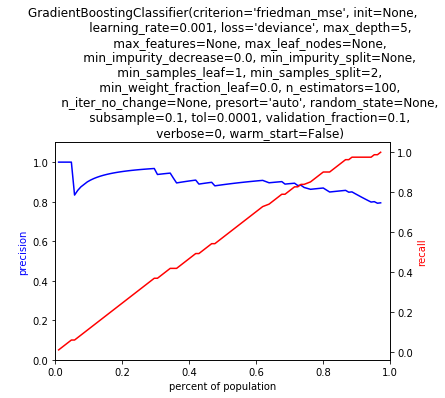

<Figure size 432x288 with 0 Axes>

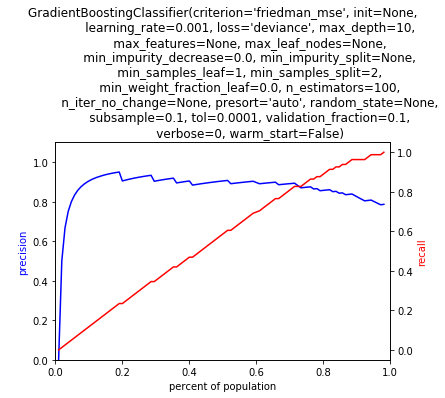

<Figure size 432x288 with 0 Axes>

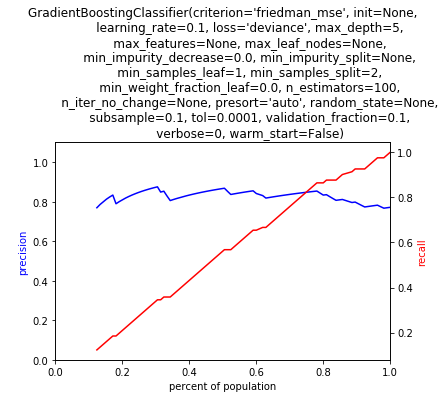

<Figure size 432x288 with 0 Axes>

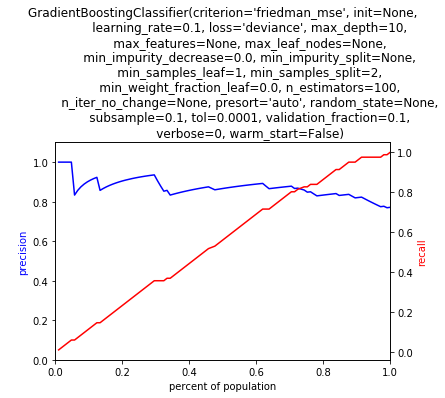

LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

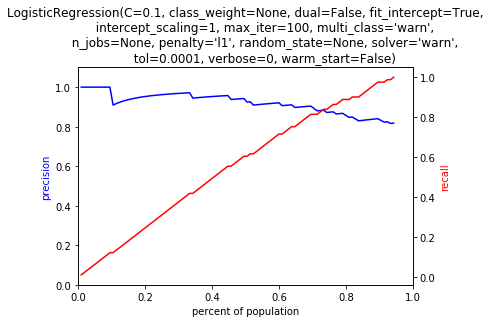

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

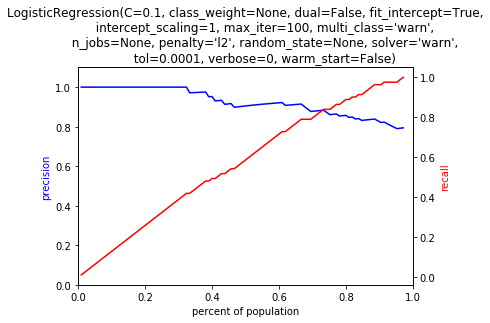

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

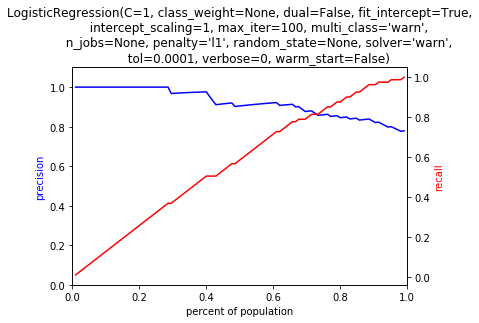

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

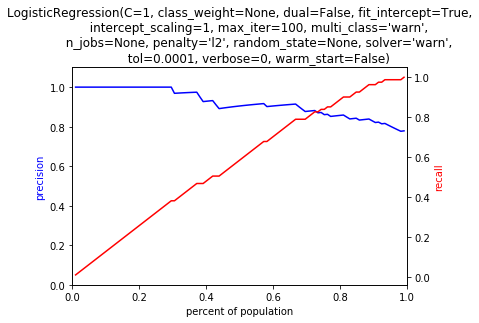

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

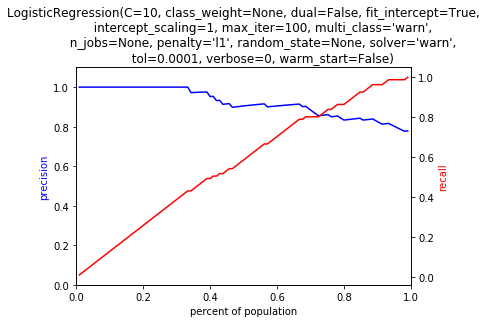

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

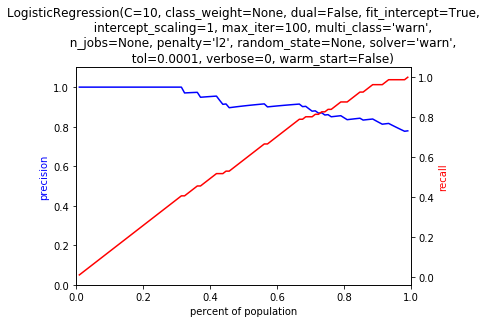

In [98]:
# define grid to use: test, small, large
grid_size = 'small'

    # define models to run
models_to_run=['GB', 'LR']

results_df = clf_loop(models_to_run, clfs, small_grid, X,y)

GB


<Figure size 432x288 with 0 Axes>

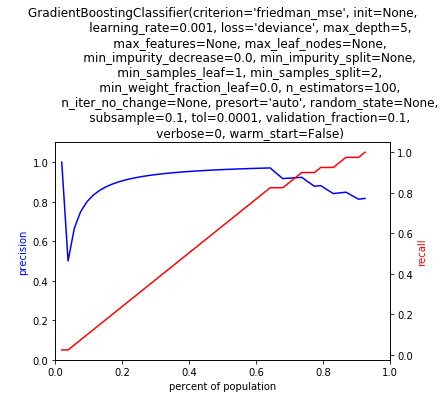

<Figure size 432x288 with 0 Axes>

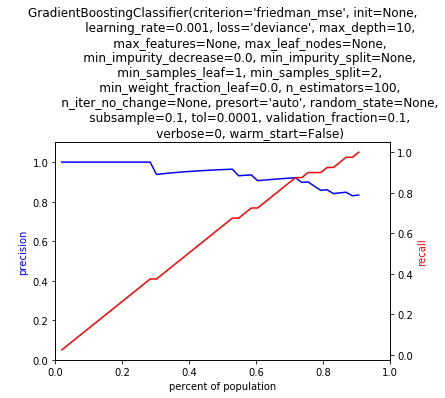

<Figure size 432x288 with 0 Axes>

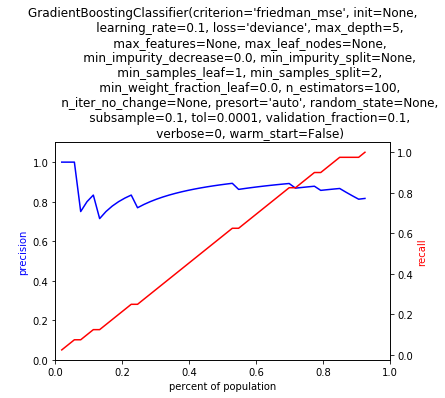

<Figure size 432x288 with 0 Axes>

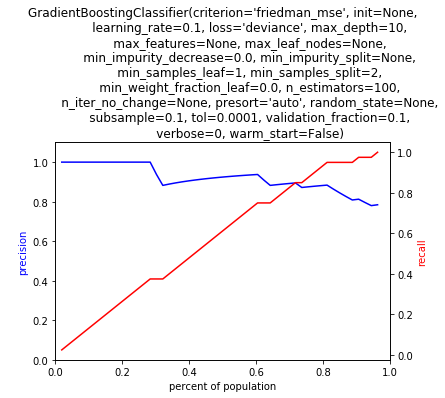

LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

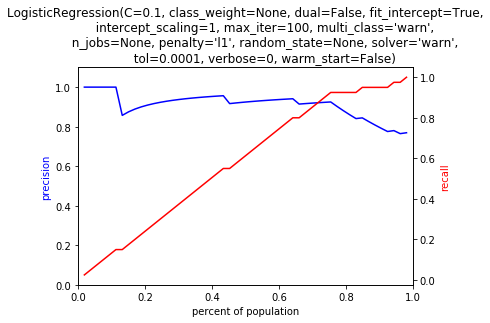

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

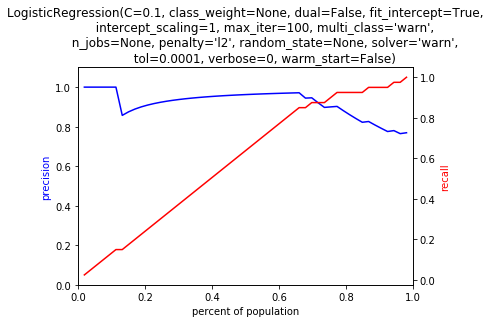

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

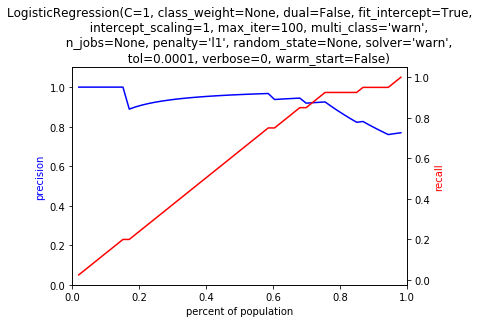

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

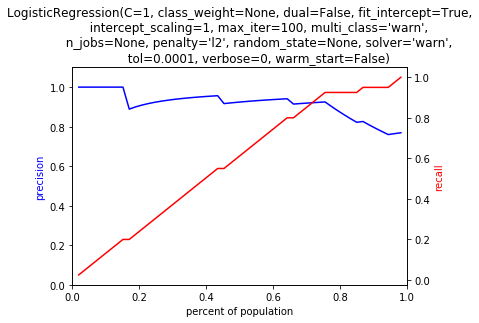

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

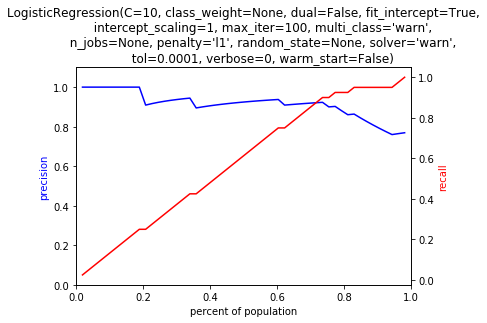

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

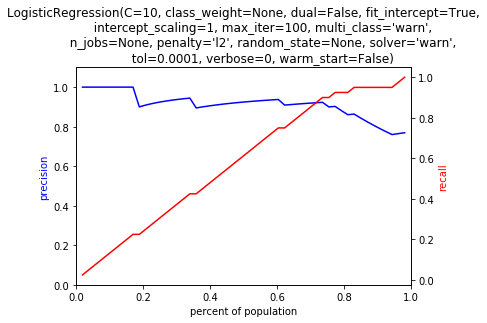

In [99]:
# define grid to use: test, small, large
grid_size = 'small'

    # define models to run
models_to_run=['GB', 'LR']

results_df_non_singleton = clf_loop(models_to_run, clfs, small_grid, X_non_singleton,y_non_singleton)

In [100]:
results_df.sort_values('p_at_40',ascending=False).head(10)

,model_type,clf,parameters,p_at_20,p_at_40
6,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l1'}",1.000000,0.976190
4,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l1'}",0.952381,0.952381
5,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l2'}",1.000000,0.952381
8,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l1'}",1.000000,0.952381
9,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l2'}",1.000000,0.952381
7,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l2'}",1.000000,0.928571
0,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}",0.952381,0.904762
1,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",0.904762,0.904762
3,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",0.904762,0.857143
2,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}",0.809524,0.833333


In [101]:
results_df_non_singleton.sort_values('p_at_40',ascending=False).head(10)

,model_type,clf,parameters,p_at_20,p_at_40
0,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}",0.9,0.952381
1,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",1.0,0.952381
4,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l1'}",0.9,0.952381
5,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l2'}",0.9,0.952381
6,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l1'}",0.9,0.952381
7,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l2'}",0.9,0.952381
3,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",1.0,0.904762
8,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l1'}",1.0,0.904762
9,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l2'}",0.9,0.904762
2,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}",0.8,0.857143


In [102]:
chosen_model = LogisticRegression(**{'C': 1, 'penalty': 'l1'})

In [103]:
fitted_model = chosen_model.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [105]:
pickle.dump(fitted_model, open('fitted_model.pkl','wb'))

In [133]:
coefs = fitted_model.coef_.flatten().tolist()

named_coefs = zip(mapper.transformed_names_[:len(coefs)], coefs)

sorted_named_coefs = sorted(named_coefs, key=lambda tup: tup[1])

for name, coef in sorted_named_coefs:
    print(name,coef)

goodfaith_timestamps_total_seconds -0.6021093330706702
goodfaith_scores_var -0.4165019016570169
edit_wars -0.4161213065461215
goodfaith_scores_count_log -0.3789496616373972
pages_talk_count -0.181371690473727
first_edit_ores_damaging -0.14368492464225632
goodfaith_scores_reg_intercept -0.05477731417109812
pages_unique_count -0.039076339243352624
first_edit_ores_goodfaith -0.0034334763341600577
goodfaith_scores_min 0.0
goodfaith_scores_reg_slope 0.0
goodfaith_scores_count 0.0
goodfaith_timestamps_variance 0.0
goodfaith_timestamps_min 0.0
singleton_session 0.0
any_edit_ores_goodfaith 0.0
pages_namespace_count 0.056362586855027
any_edit_ores_damaging 0.08219302715685123
pages_nonmain_count 0.12355809204468697
self_reverts 0.19637678203925366
goodfaith_scores_max 0.23995742758552016
goodfaith_timestamps_max 0.8644874736820558
goodfaith_scores_mean 1.092141484849392


# Predict Today

In [206]:
hb_j = json.load(open('/home/paprika/Downloads/quarry-hostbot.json'))
col_names_hb = hb_j['headers']
rows_hb = hb_j['rows']

hb = pd.DataFrame.from_records(rows_hb, columns=col_names_hb)

In [ ]:
reg_j= json.load(open('/home/paprika/workspace/wikilabels_data/saves/enwiki_registered_users_ge2_edits_20181123.json','r'))

col_names = reg_j['headers']
rows = reg_j['rows']

registered = pd.DataFrame.from_records(rows, columns=col_names)

In [24]:
def get_last_user_contribs_upto_date(user_id, end_date):
    user_q = session.get(action='query', list='usercontribs', ucuserids=user_id, ucstart=end_date)
    return user_q['query']['usercontribs']

In [25]:
registered['usercontribs'] = registered.apply(lambda row: get_last_user_contribs_upto_date(user_id=row['user_id'], end_date=row['NOW()']), axis=1)

In [26]:
# registered_s = registered.iloc[30:130]

In [27]:
# registered_s['usercontribs'] = registered_s.apply(lambda row: get_last_user_contribs_upto_date(user_id=row['user_id'], end_date=row['NOW()']), axis=1)

In [28]:
# this removes sessions which have for some reasons been deleted or errored
registered['rev_ids'] = registered['usercontribs'].apply(lambda l: [e['revid'] for e in l])
registered = registered[registered['rev_ids'].apply(lambda l: len(l)>0)]
registered['timestamps'] = registered['usercontribs'].apply(lambda l: [dt.datetime.strptime(e['timestamp'], "%Y-%m-%dT%H:%M:%SZ")  for e in l])


## need to move from a 1 user-per-row to 1 session-per-row

In [29]:
def make_sessions(rev_df):
    #these structures store the timestamps
    rev_df = rev_df.sort_values('timestamp')
    edit_sessions = []
    curr_edit_session = []

    #initialize prev to the earliest data possible
    prev_timestamp = dt.datetime(year=2001, month=1, day=1)

    for index, (globindex, row) in enumerate(rev_df.iterrows()):
#         print('index:', index)
        curr_timestamp = dt.datetime.strptime(row['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
        revid = row['revid']
        #if curr timestamp within 1 hour of last then append
        if curr_timestamp - prev_timestamp < dt.timedelta(hours=1):
            curr_edit_session.append({'timestamp':curr_timestamp, 'revid':revid})
        # else start a new edit session
        else:
            #if there's a pre-existing session save it to the return
            if curr_edit_session:
                edit_sessions.append(curr_edit_session)
            # and start a new session
            curr_edit_session = [{'timestamp':curr_timestamp, 'revid':revid}]
        # this is before
        if index < len(rev_df)-1:
            prev_timestamp = curr_timestamp
        # this is the last item save this session too.
        else:
#             print('this is the end')
            edit_sessions.append(curr_edit_session)
        
    return edit_sessions

def sessionify(user_df):
    user_session_dfs = []
    rev_df = pd.DataFrame.from_dict(user_df['usercontribs'].iloc[0])
#     print(rev_df)
    sessions = make_sessions(rev_df)
#     print(user_df['user_id'].iloc[0])
    for edit_session in sessions:
        session_df = user_df.copy()
        session_df['session_data'] = session_df['user_name'].apply(lambda nothing:edit_session)
        user_session_dfs.append(session_df)
#         print(session)
#     print('##########')
#     print(user_session_dfs)
    return pd.concat(user_session_dfs)

In [30]:
sessions = registered.groupby('user_id').apply(sessionify)

In [31]:
sessions.shape

(1088, 9)

In [61]:
sessions['session_timestamps'] = sessions['session_data'].apply(lambda l: [e['timestamp']  for e in l])
sessions['session_rev_ids'] = sessions['session_data'].apply(lambda l: [e['revid']  for e in l])


In [72]:
def num_reverts(revids):
    self_reverts = 0
    reverting_users = defaultdict(int)
    for rev_id in revids:
        try:
            _, reverted, reverted_to = mwreverts.api.check(
                session, rev_id, radius=2,  # most reverts within 5 edits
                window=48*60*60,  # 2 days
                rvprop={'user', 'ids'})  # Some properties we'll make use of
        except (RuntimeError, KeyError) as e:
            sys.stderr.write(str(e))
            continue
            
        if reverted is not None:
            
            reverting_user = reverted.reverting['user']
            reverting_users[reverting_user] += 1
            
            reverted_doc = [r for r in reverted.reverteds
                            if r['revid'] == rev_id][0]

            if 'user' not in reverted_doc or 'user' not in reverted.reverting:
                continue

            # self-reverts
            self_revert = \
                reverted_doc['user'] == reverting_user

            if self_revert:
                self_reverts += 1
    
    edit_war_users = [user for user, num_reverts in reverting_users.items() if num_reverts > 1]
    edit_wars = len(edit_war_users)
    
    return {'self_reverts': self_reverts, 'edit_wars':edit_wars}

def simp_lin_reg(vec,slope_intercept='slope'):
    if len(vec)==1:
        return 0
    else:
        x=list(range(len(vec)))
        reg = np.polyfit(x,vec,1)
        return reg[0] if slope_intercept == 'slope' else reg[1]
    
ores_count = 0
def get_ores_data_dgf(rev_ids, context='enwiki'):
    global ores_count
    ores_count+=1
    if ores_count % 100 ==0:
        print('ores count: {0}'.format(ores_count))
#     print(f'getting {len(rev_ids)} revs')
    ores_string = 'https://ores.wikimedia.org/v3/scores/{context}/{revid}/{model}'
    models = ('damaging', 'goodfaith')
    ores_data = {}
    for model in ('damaging', 'goodfaith'):
        ores_data[model] = []
        for rev_id in rev_ids:
            ores_req = ores_string.format(context=context, revid=rev_id, model=model)
            ores_resp = requests.get(url=ores_req)
            json_data = ores_resp.json()
            try:
                ores_datum_raw = json_data[context]['scores'][str(rev_id)][model]['score']
                ores_datum = {'prediction':ores_datum_raw['prediction'],'prob_true':ores_datum_raw['probability']['true']}
                ores_data[model].append(ores_datum)
            except KeyError:
                ores_data[model].append(float('nan'))
    return ores_data

def total_seconds(timestamps):
    if len(timestamps)==1:
        return 60*60 # one hour
    else:
        delta = max(timestamps) - min(timestamps)
        return 60*60 + delta.seconds #one hour plus the difference
     
def fn_seconds(timestamps, fn):
    timestamps = sorted(timestamps)
    if len(timestamps)==1:
        return 0 #no variance
    else:
        deltas = []
        for i in range(len(timestamps)-1):
            deltas.append(timestamps[i+1]-timestamps[1])
        delta_seconds = [d.seconds for d in deltas]
        return fn(delta_seconds)
    
def page_dicts_of_session(row):
    sess_revids = [r['revid'] for r in row['session_data']]
    sess_contribs = [c for c in row['usercontribs'] if c['revid'] in sess_revids]
    sess_pages = [{'page_id':c['pageid'],'page_ns':c['ns']} for c in sess_contribs]
    return sess_pages
    
def make_features(df):
    df['pages'] = df.apply(lambda row: page_dicts_of_session(row), axis=1)
    print('getting ores data')
    df['ores_data'] = df['session_rev_ids'].apply(get_ores_data_dgf)
    print('getting revert data')
    df['revert_data'] = df['session_rev_ids'].apply(lambda x: num_reverts(x))

    df['damaging_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['damaging'] if isinstance(e, dict)])
    df['goodfaith_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['goodfaith'] if isinstance(e, dict)])
    df['damaging_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['damaging'] if isinstance(e, dict)])
    df['goodfaith_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['goodfaith'] if isinstance(e, dict)])

    missing_goodfaith = df[df['goodfaith_scores'].apply(lambda l: len(l)==0)]
    print('missing goodfaith were: {}'.format(len(missing_goodfaith)))
    
    df = df[df['goodfaith_scores'].apply(lambda l: len(l)>0)]
    
    df['self_reverts'] = df['revert_data'].apply(lambda d: d['self_reverts'])
    df['edit_wars'] = df['revert_data'].apply(lambda d: d['edit_wars'])
    print('doing meta statistics')
    df['goodfaith_scores_mean'] = df['goodfaith_scores'].apply(np.mean)
    df['goodfaith_scores_var'] = df['goodfaith_scores'].apply(np.var)
    df['goodfaith_scores_max'] = df['goodfaith_scores'].apply(max)
    df['goodfaith_scores_min'] = df['goodfaith_scores'].apply(min)
    df['goodfaith_scores_reg_slope'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'slope'))
    df['goodfaith_scores_reg_intercept'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'intercept'))
    df['goodfaith_scores_count'] = df['goodfaith_scores'].apply(len)
    df['goodfaith_scores_count_log'] = df['goodfaith_scores'].apply(lambda v: np.log(len(v)))
    
    print('doing time stats')
    #     df['damaging_timestamps_total_seconds'] = df['session_timestamps'].apply(total_seconds)
    #     df['damaging_timestamps_variance'] = df['session_timestamps'].apply(lambda t: fn_seconds(t, np.var))
    #     df['damaging_timestamps_min'] = df['session_timestamps'].apply(lambda t: fn_seconds(t, np.min))
    #     df['damaging_timestamps_max'] = df['session_timestamps'].apply(lambda t: fn_seconds(t, np.max))

    df['goodfaith_timestamps_total_seconds'] = df['session_timestamps'].apply(total_seconds)
    df['goodfaith_timestamps_variance'] = df['session_timestamps'].apply(lambda t: fn_seconds(t, np.var))
    df['goodfaith_timestamps_min'] = df['session_timestamps'].apply(lambda t: fn_seconds(t, np.min))
    df['goodfaith_timestamps_max'] = df['session_timestamps'].apply(lambda t: fn_seconds(t, np.max))

    df['pages_unique_count'] = df['pages'].apply(lambda plist: len(set([p['page_id'] for p in plist])))
    df['pages_namespace_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist])))
    df['pages_nonmain_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']!=0])))
    df['pages_talk_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']%2==1])))

    df['singleton_session'] = df['rev_ids'].apply(lambda rev_ids: len(rev_ids)==1)

    df['first_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: predictions[0])
    df['first_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: predictions[0])
    df['any_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: any(predictions))
    df['any_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: any(predictions))
    return df


# def map_to_matrix(df, with_label=False):    
#     mapper = DataFrameMapper(col_list)
#     data = mapper.(df.copy())
#     return data

In [73]:
# %%capture
sessions_featured = make_features(sessions)

getting ores data
ores count: 100
ores count: 200
ores count: 300
ores count: 400
ores count: 500
ores count: 600
ores count: 700
ores count: 800
ores count: 900
ores count: 1000
getting revert data
missing goodfaith were: 2
doing meta statistics


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

doing time stats


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

In [74]:
sessions_featured.shape

(1086, 41)

In [75]:
sessions_featured.to_pickle('/home/paprika/workspace/wikilabels_data/saves/sessions_featured.pickle')

In [90]:
registered_featured.to_pickle('/home/paprika/workspace/wikilabels_data/saves/registered_featured.pickle')

In [202]:
registered_featured = pd.read_pickle('/home/paprika/workspace/wikilabels_data/saves/registered_featured.pickle')

In [106]:
### Later, in another file
mapper = pickle.load(open('fitted_mapper.pkl', 'rb'))
model = pickle.load(open('fitted_model.pkl','rb'))

In [95]:
%%capture
registered_featured_mapped = mapper.transform(registered_featured.copy())

In [107]:
%%capture
sessions_featured_mapped = mapper.transform(sessions_featured.copy())

In [108]:
sessions_featured_mapped.shape

(1086, 23)

In [114]:
sessions_probas = model.predict_proba(sessions_featured_mapped)

In [115]:
sessions_probas

array([[0.11982959, 0.88017041],
       [0.02920778, 0.97079222],
       [0.84876334, 0.15123666],
       ...,
       [0.60927935, 0.39072065],
       [0.13749221, 0.86250779],
       [0.50760326, 0.49239674]])

In [116]:
sessions_goodfaith_proba = sessions_probas[:,1:]

In [117]:
sessions_featured['goodfaith_proba'] = sessions_goodfaith_proba

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [120]:
sessions_featured['wlinks'] = sessions_featured['rev_ids'].apply(lambda rl: [wlink(r) for r in rl])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [125]:
sessions_featured.sort_values('goodfaith_proba', ascending=False).head(10)

,,user_id,user_name,user_registration,user_editcount,NOW(),usercontribs,rev_ids,timestamps,session_data,pages,...,pages_namespace_count,pages_nonmain_count,pages_talk_count,singleton_session,first_edit_ores_goodfaith,first_edit_ores_damaging,any_edit_ores_goodfaith,any_edit_ores_damaging,goodfaith_proba,wlinks
user_id,,,,,,,,,,,,,,,,,,,,,,
35206775,470,35206775,TweetFossilNeil,20181122235948,5,2018-11-23T22:37:00,"[{'userid': 35206775, 'user': 'TweetFossilNeil', 'pageid': 41156043, 'revid': 870216277, 'parentid': 869854055, 'ns': 0, 'title': 'Gurleen Chopra', 'timestamp': '2018-11-23T07:19:12Z', 'comment': '', 'size': 7574}, {'userid': 35206775, 'user': 'T...","[870216277, 870187322, 870179474, 870179430, 870179362]","[2018-11-23 07:19:12, 2018-11-23 01:44:17, 2018-11-23 00:04:37, 2018-11-23 00:04:12, 2018-11-23 00:03:32]","[{'timestamp': 2018-11-23 01:44:17, 'revid': 870187322}]","[{'page_id': 59134566, 'page_ns': 118}]",...,1,1,0,False,True,False,True,False,0.986649,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=870216277&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870187322&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870179474&diffmode=source, https..."
35199404,62,35199404,JDNAScreative,20181122022641,3,2018-11-23T22:37:00,"[{'userid': 35199404, 'user': 'JDNAScreative', 'pageid': 59127460, 'revid': 870089490, 'parentid': 870079458, 'ns': 118, 'title': 'Draft:Darren Palmer', 'timestamp': '2018-11-22T08:50:07Z', 'comment': '', 'size': 12162}, {'userid': 35199404, 'use...","[870089490, 870079458, 870065570]","[2018-11-22 08:50:07, 2018-11-22 06:46:31, 2018-11-22 04:20:50]","[{'timestamp': 2018-11-22 08:50:07, 'revid': 870089490}]","[{'page_id': 59127460, 'page_ns': 118}]",...,1,1,0,False,True,False,True,False,0.986578,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=870089490&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870079458&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870065570&diffmode=source]"
35200257,109,35200257,JensenCh1972,20181122054306,9,2018-11-23T22:37:00,"[{'userid': 35200257, 'user': 'JensenCh1972', 'pageid': 6267822, 'revid': 870302147, 'parentid': 866700231, 'ns': 0, 'title': 'Randall Park Mall', 'timestamp': '2018-11-23T21:47:54Z', 'top': '', 'comment': '/* Decline and closure */ Added informa...","[870302147, 870301360, 870261425, 870208735, 870192739, 870128276, 870126008, 870123643, 870122092]","[2018-11-23 21:47:54, 2018-11-23 21:41:34, 2018-11-23 15:51:46, 2018-11-23 05:46:31, 2018-11-23 02:53:12, 2018-11-22 16:02:26, 2018-11-22 15:41:18, 2018-11-22 15:18:53, 2018-11-22 15:04:19]","[{'timestamp': 2018-11-23 15:51:46, 'revid': 870261425}]","[{'page_id': 59135629, 'page_ns': 2}]",...,1,1,0,False,True,False,True,False,0.986308,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=870302147&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870301360&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870261425&diffmode=source, https..."
35202747,243,35202747,Hussainlaghari01,20181122123237,6,2018-11-23T22:37:00,"[{'userid': 35202747, 'user': 'Hussainlaghari01', 'pageid': 59130213, 'revid': 870115353, 'parentid': 870114305, 'ns': 2, 'title': 'User:Hussainlaghari01/sandbox', 'timestamp': '2018-11-22T13:58:13Z', 'top': '', 'comment': '/* Crops */', 'size': ...","[870115353, 870114305, 870114090, 870113864, 870113788, 870107798]","[2018-11-22 13:58:13, 2018-11-22 13:49:19, 2018-11-22 13:47:47, 2018-11-22 13:45:29, 2018-11-22 13:44:41, 2018-11-22 12:37:44]","[{'timestamp': 2018-11-22 12:37:44, 'revid': 870107798}]","[{'page_id': 59130213, 'page_ns': 2}]",...,1,1,0,False,True,False,True,False,0.986127,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=870115353&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870114305&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870114090&diffmode=source, https..."
35206910

In [124]:
sessions_featured.sort_values('goodfaith_proba', ascending=False).tail(3)

,,user_id,user_name,user_registration,user_editcount,NOW(),usercontribs,rev_ids,timestamps,session_data,pages,...,pages_namespace_count,pages_nonmain_count,pages_talk_count,singleton_session,first_edit_ores_goodfaith,first_edit_ores_damaging,any_edit_ores_goodfaith,any_edit_ores_damaging,goodfaith_proba,wlinks
user_id,,,,,,,,,,,,,,,,,,,,,,
35203254,272,35203254,AloadOfBull,20181122134511,6,2018-11-23T22:37:00,"[{'userid': 35203254, 'user': 'AloadOfBull', 'pageid': 52410771, 'revid': 870116307, 'parentid': 870115821, 'ns': 0, 'title': 'Honey G', 'timestamp': '2018-11-22T14:08:36Z', 'comment': '', 'size': 473}, {'userid': 35203254, 'user': 'AloadOfBull',...","[870116307, 870116063, 870115424, 870115012, 870114874, 870114549]","[2018-11-22 14:08:36, 2018-11-22 14:05:56, 2018-11-22 13:59:01, 2018-11-22 13:54:46, 2018-11-22 13:53:16, 2018-11-22 13:50:51]","[{'timestamp': 2018-11-22 13:50:51, 'revid': 870114549}, {'timestamp': 2018-11-22 13:53:16, 'revid': 870114874}, {'timestamp': 2018-11-22 13:54:46, 'revid': 870115012}, {'timestamp': 2018-11-22 13:59:01, 'revid': 870115424}, {'timestamp': 2018-11...","[{'page_id': 52410771, 'page_ns': 0}, {'page_id': 9088190, 'page_ns': 0}, {'page_id': 52410771, 'page_ns': 0}, {'page_id': 49989265, 'page_ns': 0}, {'page_id': 49989265, 'page_ns': 0}, {'page_id': 49989265, 'page_ns': 0}]",...,1,0,0,False,False,True,False,True,0.041746,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=870116307&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870116063&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870115424&diffmode=source, https..."
35200866,145,35200866,Ben jamine E 27 27 27,20181122073826,10,2018-11-23T22:37:00,"[{'userid': 35200866, 'user': 'Ben jamine E 27 27 27', 'pageid': 48607, 'revid': 870088107, 'parentid': 870050046, 'ns': 0, 'title': 'Memphis, Tennessee', 'timestamp': '2018-11-22T08:31:59Z', 'comment': 'Modernized the population count.', 'size':...","[870088107, 870087601, 870087272, 870086809, 870086499, 870086257, 870085898, 870085368, 870084174, 870084082]","[2018-11-22 08:31:59, 2018-11-22 08:25:18, 2018-11-22 08:20:39, 2018-11-22 08:15:02, 2018-11-22 08:11:16, 2018-11-22 08:08:02, 2018-11-22 08:03:11, 2018-11-22 07:56:38, 2018-11-22 07:42:07, 2018-11-22 07:41:06]","[{'timestamp': 2018-11-22 07:41:06, 'revid': 870084082}, {'timestamp': 2018-11-22 07:42:07, 'revid': 870084174}, {'timestamp': 2018-11-22 07:56:38, 'revid': 870085368}, {'timestamp': 2018-11-22 08:03:11, 'revid': 870085898}, {'timestamp': 2018-11...","[{'page_id': 48607, 'page_ns': 0}, {'page_id': 13072449, 'page_ns': 0}, {'page_id': 49281386, 'page_ns': 0}, {'page_id': 1138003, 'page_ns': 0}, {'page_id': 703807, 'page_ns': 0}, {'page_id': 1268366, 'page_ns': 0}, {'page_id': 8209, 'page_ns': 0...",...,1,0,0,False,False,True,True,True,0.040444,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=870088107&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870087601&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=870087272&diffmode=source, https..."
35207215,501,35207215,Yo800,20181123021244,18,2018-11-23T22:37:00,"[{'userid': 35207215, 'user': 'Yo800', 'pageid': 58397071, 'revid': 870191778, 'parentid': 869890288, 'ns': 4, 'title': 'Wikipedia:Arbitration Committee Elections December 2018', 'timestamp': '2018-11-23T02:39:59Z', 'comment': '', 'size': 11063},...","[870191778, 870191642, 870191535, 870191454, 870191375, 870191302, 870191276, 870191172, 870191132, 870191100]","[2018-11-23 02:39:59, 2018-11-23 02:38:27, 2018-11-23 02:37:03, 2018-11-23 02:36:10, 2018-11-23 02:35:11, 2018-11-23 02:34:07, 2018-11-23 02:33:50, 2018-11-23 02:32:33, 2018-11-23 02:31:57, 2018-11-23 02:31:28]","[{'timestamp': 2018-11-23 02:31:28, 'revid': 870191100}, {'timestamp': 2018-11-23 02:31:57, 'revid': 870191132}, {'timestamp': 2018-11-23 02:32:33, 'revid': 870191172}, {'timestamp': 2018-11-23 02:33:50, 'revid': 870191276}, {'timestamp': 2018-11...","[{'

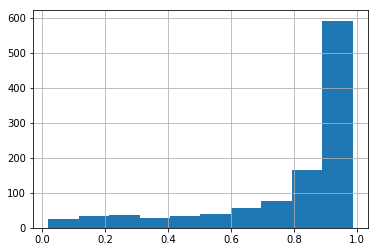

In [126]:
sessions_featured['goodfaith_proba'].hist()

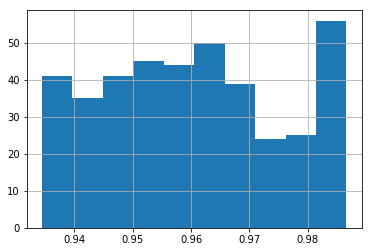

In [132]:
sessions_featured.sort_values('goodfaith_proba',ascending=False).iloc[:400]['goodfaith_proba'].hist()

In [165]:
users_probas = sessions_featured.groupby('user_id').goodfaith_proba.mean().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


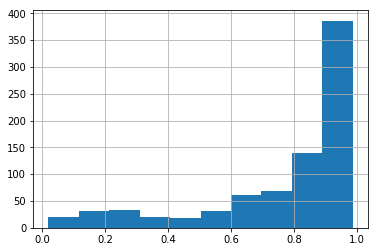

In [166]:
users_probas['goodfaith_proba'].hist()

In [167]:
sessions.head(1)

,,user_id,user_name,user_registration,user_editcount,NOW(),usercontribs,rev_ids,timestamps,session_data,pages,...,ores_data,revert_data,self_reverts,edit_wars,damaging_scores,goodfaith_scores,damaging_predictions,goodfaith_predictions,goodfaith_scores_mean,goodfaith_scores_var
user_id,,,,,,,,,,,,,,,,,,,,,,
35198440,0,35198440,Jessicamaehubbard,20181121223814,4,2018-11-23T22:37:00,"[{'userid': 35198440, 'user': 'Jessicamaehubbard', 'pageid': 53480675, 'revid': 870038201, 'parentid': 870029399, 'ns': 0, 'title': 'The Badger (newspaper)', 'timestamp': '2018-11-21T23:55:48Z', 'top': '', 'comment': '', 'size': 4990}, {'userid':...","[870038201, 870029708, 870029399, 870029110]","[2018-11-21 23:55:48, 2018-11-21 22:46:47, 2018-11-21 22:44:20, 2018-11-21 22:42:12]","[{'timestamp': 2018-11-21 22:42:12, 'revid': 870029110}, {'timestamp': 2018-11-21 22:44:20, 'revid': 870029399}, {'timestamp': 2018-11-21 22:46:47, 'revid': 870029708}]","[{'page_id': 55993831, 'page_ns': 0}, {'page_id': 53480675, 'page_ns': 0}, {'page_id': 53480675, 'page_ns': 0}]",...,"{'damaging': [{'prediction': False, 'prob_true': 0.36456977621083564}, {'prediction': False, 'prob_true': 0.34138625409388956}, {'prediction': False, 'prob_true': 0.3004932919727388}], 'goodfaith': [{'prediction': True, 'prob_true': 0.73839371574...","{'self_reverts': 0, 'edit_wars': 0}",0,0,"[0.36456977621083564, 0.34138625409388956, 0.3004932919727388]","[0.7383937157468207, 0.7743663808895388, 0.7889606552084288]","[False, False, False]","[True, True, True]",0.76724,0.000452


In [172]:
users_probas = users_probas.merge(registered[['user_id','user_name']])

In [266]:
def contrib_link(user_name):
    contrib_str = 'https://en.wikipedia.org/w/index.php?limit=50&title=Special%3AContributions&contribs=user&target={user_name}&namespace=&tagfilter=&start=2018-11-21&end=2018-11-24'
    csf = contrib_str.format(user_name=user_name.replace(" ","_"))
    return f'[{csf} Contribs of {user_name}]'

In [267]:
print(contrib_link('Maximilianklein'))

[https://en.wikipedia.org/w/index.php?limit=50&title=Special%3AContributions&contribs=user&target=Maximilianklein&namespace=&tagfilter=&start=2018-11-21&end=2018-11-24 Contribs of Maximilianklein]


In [268]:
users_probas['clink'] = users_probas['user_name'].apply(contrib_link)

In [269]:
users_probas_300 = users_probas.sort_values('goodfaith_proba',ascending=False).iloc[:300]

In [270]:
hb_300 = hb.iloc[:300]

In [271]:
hb_users = set(hb_300['user_name'])
ai_users = set(users_probas_300['user_name'])

In [272]:
both_users = hb_users.intersection(ai_users)

In [273]:
ai_not_hb = ai_users.difference(hb_users)
hb_not_ai = hb_users.difference(ai_users)

In [274]:
hb_300['hostbot_recommendation'] = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [275]:
ai_hb = pd.merge(hb_300[['user_name','hostbot_recommendation']], users_probas_300[['user_name','goodfaith_proba']], on='user_name', how='outer')

In [276]:
ai_hb['hostbot_recommendation'] = ai_hb['hostbot_recommendation'].fillna(False)
ai_hb['goodfaith_proba'] = ai_hb['goodfaith_proba'].fillna('n/a')
ai_hb['contrib_link'] = ai_hb['user_name'].apply(contrib_link)

In [278]:
print(ai_hb.sort_values('user_name').to_html(index=False, escape=False, border=0))

<table border="0" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>user_name</th>
      <th>hostbot_recommendation</th>
      <th>goodfaith_proba</th>
      <th>contrib_link</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>15EK11</td>
      <td>True</td>
      <td>n/a</td>
      <td>[https://en.wikipedia.org/w/index.php?limit=50&title=Special%3AContributions&contribs=user&target=15EK11&namespace=&tagfilter=&start=2018-11-21&end=2018-11-24 Contribs of 15EK11]</td>
    </tr>
    <tr>
      <td>3 K A Y 0</td>
      <td>False</td>
      <td>0.926602</td>
      <td>[https://en.wikipedia.org/w/index.php?limit=50&title=Special%3AContributions&contribs=user&target=3_K_A_Y_0&namespace=&tagfilter=&start=2018-11-21&end=2018-11-24 Contribs of 3 K A Y 0]</td>
    </tr>
    <tr>
      <td>Abeshk</td>
      <td>True</td>
      <td>n/a</td>
      <td>[https://en.wikipedia.org/w/index.php?limit=50&title=Special%3AContributions&contribs=user&target=Abeshk&namespace=&tagfi

In [ ]:
ai_hb

In [ ]:
def get_ores_data_dgf_batched(rev_ids, context='enwiki'):
    ores_data = {} #mapping between rev_id and ores_data
    model = "|".join('damaging', 'goodfaith')
    for batch_index in range(0, len(rev_ids), 50) # step through 50 at a time
    ores_string = 'https://ores.wikimedia.org/v3/scores/{context}/{revid}/{model}
        for rev_id in rev_ids:
            ores_req = ores_string.format(context=context, revid=rev_id, model=model)
            ores_resp = requests.get(url=ores_req)
            json_data = ores_resp.json()
            try:
                ores_datum_raw = json_data[context]['scores'][str(rev_id)][model]['score']
                ores_datum = {'prediction':ores_datum_raw['prediction'],'prob_true':ores_datum_raw['probability']['true']}
                ores_data[model].append(ores_datum)
            except KeyError:
                ores_data[model].append(float('nan'))
    return ores_data


In [ ]:
from itertools import 

In [2]:
list(range(0, 1000, 50))

[0,
 50,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950]